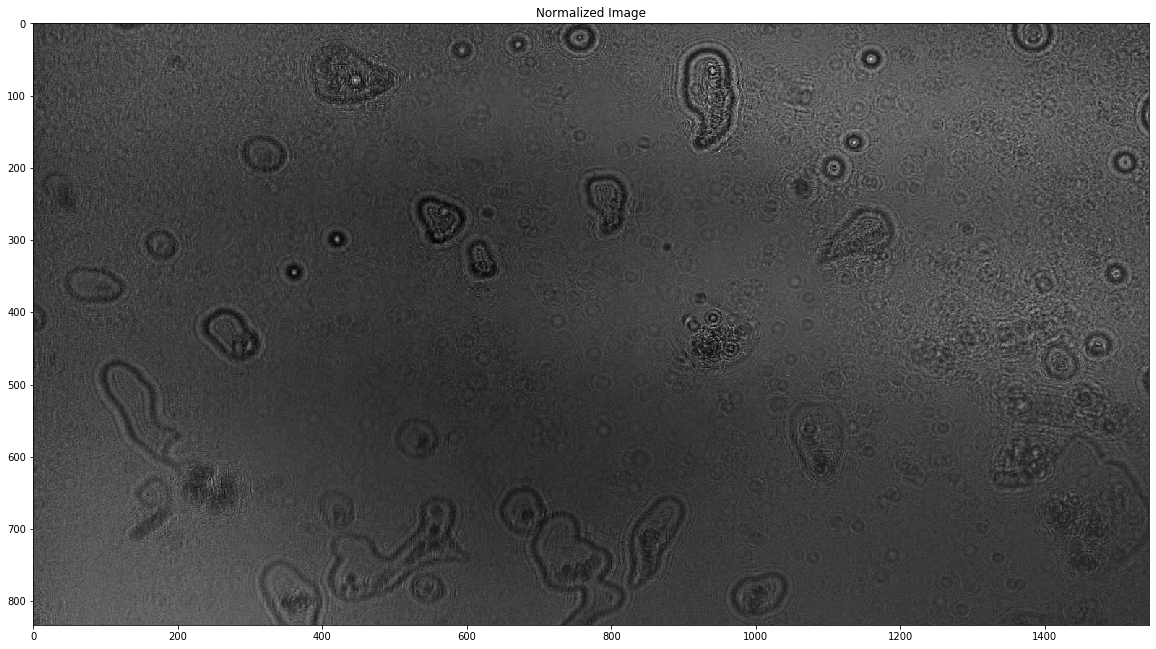

Matrix associated with the normalized image:
[[0.3426261  0.3093394  0.28622345 ... 0.35662837 0.32426216 0.30069115]
 [0.3205407  0.25719679 0.24749405 ... 0.28084095 0.19021557 0.23552826]
 [0.2966622  0.23841597 0.23102223 ... 0.31786142 0.25729324 0.24434676]
 ...
 [0.32517036 0.31547927 0.34691204 ... 0.23540397 0.23540397 0.2548237 ]
 [0.2539647  0.21882276 0.2340912  ... 0.24835046 0.24187721 0.22893073]
 [0.38927682 0.36431729 0.31947132 ... 0.24329162 0.25346238 0.24051589]]


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Let's assume we have an image URL or path
image_url = 'sample2.jpeg'  # Replace with your image path

# Read the image into an array
image = io.imread(image_url, as_gray=True)  # Read as grayscale

# Normalize the image to the range [0, 1] for intensity representation
image_normalized = image / np.max(image)

# Display the image
plt.figure(figsize=(20,20))
plt.imshow(image_normalized, cmap='gray')
plt.title('Normalized Image')
plt.show()

# Print the matrix associated with the image
print("Matrix associated with the normalized image:")
print(image_normalized)


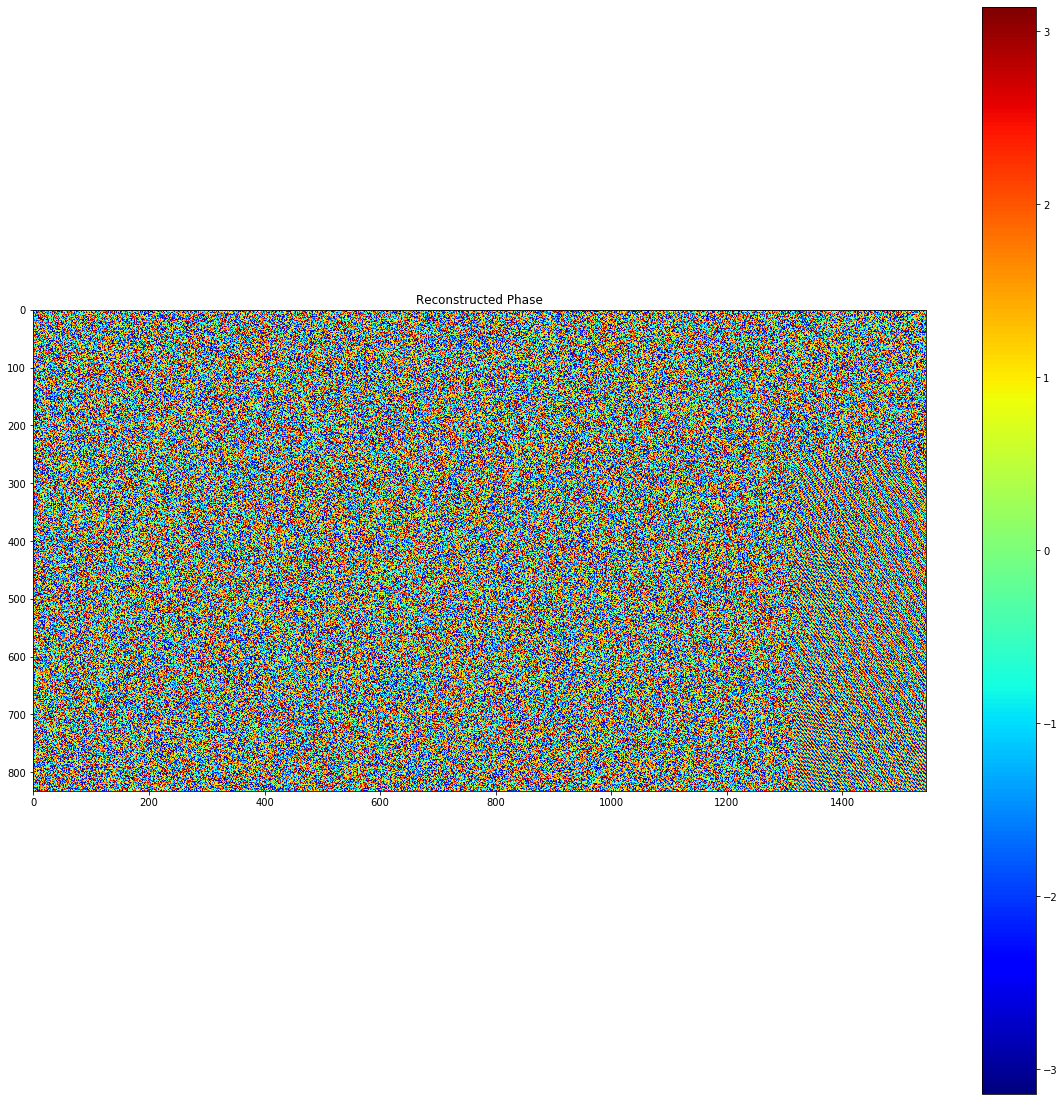

In [37]:
#import numpy as np
#import matplotlib.pyplot as plt
from skimage import color, io

# Load the hologram image
hologram_path = 'sample2.jpeg'
hologram_image = io.imread(hologram_path)
hologram_intensity = color.rgb2gray(hologram_image)  # Convert to grayscale

# Assume a random initial guess for the phase
initial_phase = np.random.rand(*hologram_intensity.shape) * 2 * np.pi

# Placeholder for the Gerchberg-Saxton algorithm
def gerchberg_saxton(intensity, initial_phase, iterations):
    # Create the initial complex field
    field = np.sqrt(intensity) * np.exp(1j * initial_phase)
    
    for i in range(iterations):
        # Apply Fourier transform to get to the frequency domain
        fourier_transformed = np.fft.fft2(field)
        
        # Replace the magnitude in the frequency domain with the measured intensity
        updated_magnitude = np.sqrt(intensity)
        field = updated_magnitude * np.exp(1j * np.angle(fourier_transformed))
        
        # Inverse Fourier transform to get back to the image domain
        field = np.fft.ifft2(field)
        
        # Enforce non-negativity in the image domain
        field = np.maximum(0, np.abs(field)) * np.exp(1j * np.angle(field))
        
    return field

def fienup_phase_retrieval(intensity, initial_phase, iterations, support, beta):
    # Create the initial guess for the object field
    field = np.sqrt(intensity) * np.exp(1j * initial_phase)
    previous_field = field.copy()

    for i in range(iterations):
        # Fourier Transform to the frequency domain
        fourier_field = np.fft.fft2(field)

        # Enforce the magnitude constraint
        fourier_field = np.sqrt(intensity) * np.exp(1j * np.angle(fourier_field))

        # Inverse Fourier Transform to the object domain
        new_field = np.fft.ifft2(fourier_field)

        # HIO update rule
        update_region = np.logical_and(support, new_field != 0)
        field[update_region] = new_field[update_region]
        field[~update_region] = previous_field[~update_region] - beta * new_field[~update_region]

        previous_field = new_field

    return field


####
object_size = 2000  # This is an example size of the object in pixels
image_size = hologram_intensity.shape
center = (image_size[0] // 2, image_size[1] // 2)

# Initialize the support mask to False
support = np.zeros_like(hologram_intensity, dtype=bool)

# Define a square region in the center of the image as the support
support[center[0]-object_size//2:center[0]+object_size//2, 
        center[1]-object_size//2:center[1]+object_size//2] = True

# Define the beta parameter
beta = 0.9
####





# Run the algorithm with a set number of iterations
iterations = 100
#reconstructed_field = gerchberg_saxton(hologram_intensity, initial_phase, iterations)
reconstructed_field = fienup_phase_retrieval(hologram_intensity, initial_phase, iterations, support, beta)

reconstructed_phase = np.angle(reconstructed_field)

# Show the reconstructed phase
figsize = (20, 20) 
plt.figure(figsize=figsize)
plt.imshow(reconstructed_phase, cmap='jet')
plt.colorbar()
plt.title('Reconstructed Phase')
plt.show()


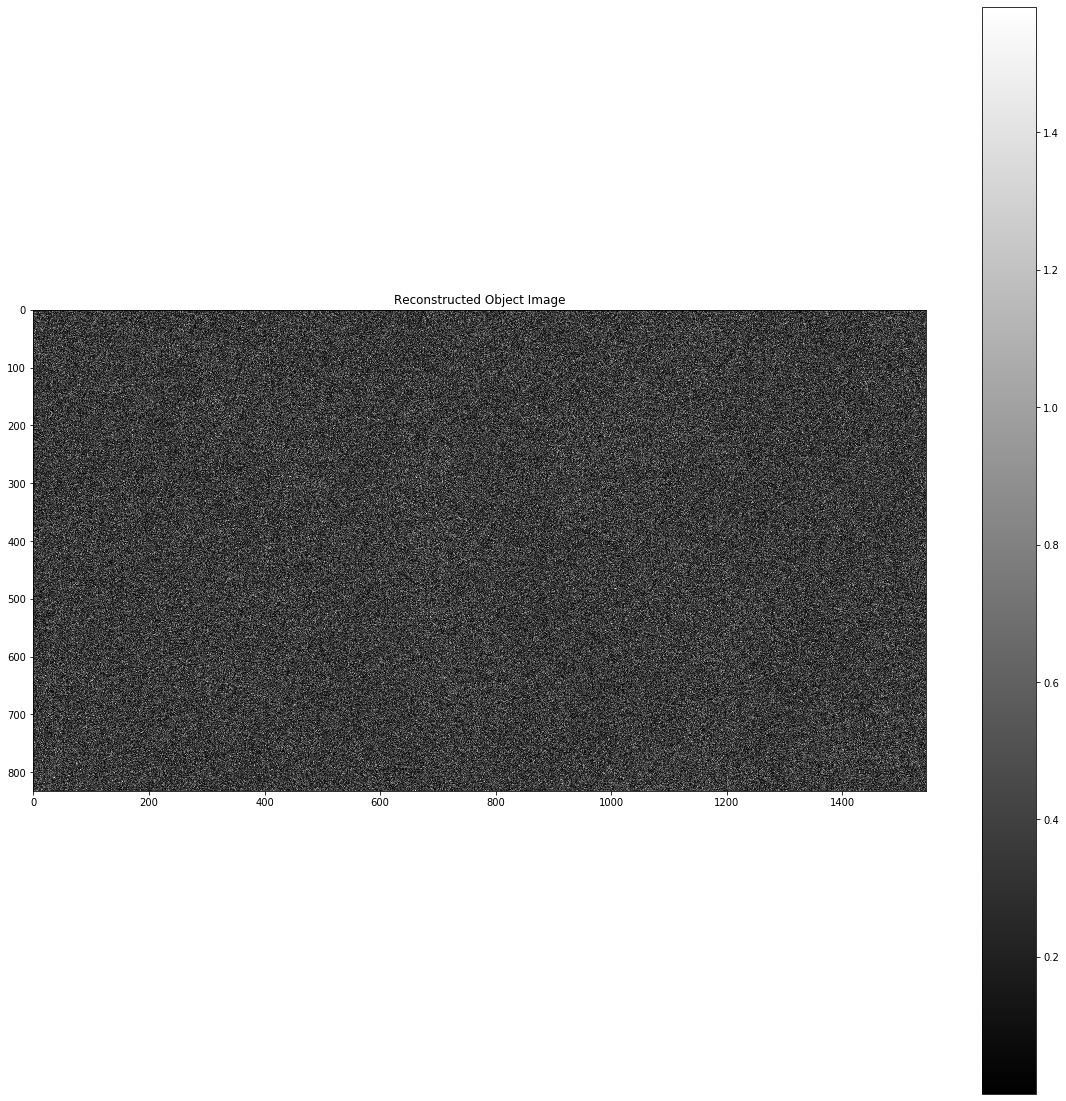

In [38]:
#import numpy as np
#import matplotlib.pyplot as plt

# Assume some parameters
wavelength = 540e-9  # Wavelength of the laser light in meters
pixel_size = 1.12e-6  # Pixel size of the camera sensor in meters
distance = 0.001  # Distance from the hologram to the object plane in meters

# Reconstructed field from previous phase retrieval
# For the purpose of this simulation, let's use the reconstructed field directly
reconstructed_field = np.sqrt(hologram_intensity) * np.exp(1j * reconstructed_phase)

# Fresnel diffraction propagation
def fresnel_propagation(field, wavelength, z, pixel_size):
    k = 2 * np.pi / wavelength  # Wave number
    nx, ny = field.shape  # Ensure the field shape is used for nx and ny
    Lx = pixel_size * nx
    Ly = pixel_size * ny
    x = np.linspace(-Lx / 2, Lx / 2, ny)  # Match the dimensions with the field
    y = np.linspace(-Ly / 2, Ly / 2, nx)  # Match the dimensions with the field
    X, Y = np.meshgrid(x, y)
    H = np.exp(1j * k * z) * np.exp(1j * k / (2 * z) * (X**2 + Y**2))
    H = np.fft.fftshift(H)  # Shift the zero to the center
    field_propagated = np.fft.ifft2(np.fft.fft2(field) * H)
    return field_propagated

# Angular spectrum propagation

def angular_spectrum_method(field, wavelength, z, pixel_size):
    k = 2 * np.pi / wavelength  # Wave number
    nx, ny = field.shape  # Dimensions of the field

    # Spatial frequencies
    fx = np.fft.fftfreq(ny, d=pixel_size)  # Frequency components in x-direction
    fy = np.fft.fftfreq(nx, d=pixel_size)  # Frequency components in y-direction
    FX, FY = np.meshgrid(fx, fy)  # Create meshgrid for frequency domain

    # Calculate the spatial frequency in the z-direction
    FZ = np.sqrt(np.maximum(0, (1 / wavelength**2 - FX**2 - FY**2)))

    # Fourier Transform of the field
    field_fourier = np.fft.fft2(field)

    # Propagation in frequency domain
    H = np.exp(1j * k * z * FZ)
    field_propagated_fourier = field_fourier * H

    # Inverse Fourier Transform to get the field in spatial domain
    field_propagated = np.fft.ifft2(field_propagated_fourier)
    return field_propagated



# Propagate the field using Angular Spectrum Method back to the object plane
object_field = angular_spectrum_method(reconstructed_field, wavelength, distance, pixel_size)

# Propagate the field using Fresnel approximation back to the object plane
#object_field = fresnel_propagation(reconstructed_field, wavelength, distance, pixel_size)

# Obtain the amplitude image of the object
object_image = np.abs(object_field)

# Show the reconstructed object image
plt.figure(figsize=(20,20))
plt.imshow(object_image, cmap='gray')
plt.title('Reconstructed Object Image')
plt.colorbar()
plt.show()


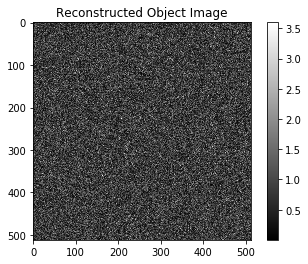

In [8]:
# reconstructing the image of the object

import numpy as np
import matplotlib.pyplot as plt

# Simulate the hologram intensity (as a placeholder, let's just use a uniform field)
hologram_intensity = np.ones((512, 512))

# Simulate a retrieved phase (in a real scenario, this would come from phase retrieval)
retrieved_phase = np.random.rand(512, 512) * 2 * np.pi

# Parameters for Fresnel propagation (assuming some typical values for illustration)
wavelength = 633e-9  # Wavelength of the laser light in meters
pixel_size = 1.12e-6  # Pixel size of the camera sensor in meters
distance = 0.01  # Distance from the hologram to the object plane in meters

# Fresnel diffraction propagation
def fresnel_propagation(field, wavelength, z, pixel_size):
    k = 2 * np.pi / wavelength  # Wave number
    nx, ny = field.shape
    Lx = pixel_size * nx
    Ly = pixel_size * ny
    x = np.linspace(-Lx / 2, Lx / 2, nx)
    y = np.linspace(-Ly / 2, Ly / 2, ny)
    X, Y = np.meshgrid(x, y)
    H = np.exp(1j * k * z) * np.exp(1j * k / (2 * z) * (X**2 + Y**2))
    H = np.fft.fftshift(H)  # Shift the zero to the center
    field_propagated = np.fft.ifft2(np.fft.fft2(field) * H)
    return field_propagated

# Combine the intensity and phase to form the reconstructed field
reconstructed_field = np.sqrt(hologram_intensity) * np.exp(1j * retrieved_phase)

# Propagate the field back to the object plane
object_field = fresnel_propagation(reconstructed_field, wavelength, distance, pixel_size)

# Obtain the amplitude image of the object
object_image = np.abs(object_field)

# Show the reconstructed object image
plt.imshow(object_image, cmap='gray')
plt.title('Reconstructed Object Image')
plt.colorbar()
plt.show()
